### Imports libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import geopandas as gpd
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap, MarkerCluster
from folium import Choropleth, Circle, Marker


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

### Functions
    Define the functions that will be used in the notebook

In [7]:
#split the dataset and scales the features afterwards
def train_test_dataset(df):    
    y = df['Exited']#.values
    X = df.drop('Exited', axis = 1)#.values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    

    columns_to_scale  = ['Score', 'Age', 'Balance', 'Salary',]
    columns_to_encode = ['Tenure', 'Products', 'Card', 'Active',
                       'Nationality_France', 'Nationality_Germany',
                       'Nationality_Spain', 'Gender_Female', 'Gender_Male']
    
    scaler = StandardScaler()
    
    tr_encoded_columns = X_train[columns_to_encode]
    tr_scaled_columns  = scaler.fit_transform(X_train[columns_to_scale])
    X_train = np.concatenate([tr_scaled_columns, tr_encoded_columns], axis=1)
    
    t_encoded_columns = X_test[columns_to_encode]
    t_scaled_columns  = scaler.fit_transform(X_test[columns_to_scale])
    X_test = np.concatenate([t_scaled_columns, t_encoded_columns], axis=1)
    
    
    return X_train, X_test, y_train, y_test

In [9]:
#receives the dataset, model and parameters to be validated via cross validation, number of interations and PCA status 
#prints the best parameters scored by F1-score
def cross_val(df, model, params, n, pca = 'no'):
    params = params
    model = model
    clf = RandomizedSearchCV(estimator= model,
                             param_distributions=params,
                             scoring='f1_weighted',
                             n_iter= n,
                             verbose=1)
    
    X_train, X_test, y_train, y_test = train_test_dataset(df)
    
    if pca == 'yes':
        pca_ = PCA(0.95) #chooses the principal components that explain 95% of the variance
        principalComponents = pca_.fit(X_train)
        X_train = pca_.transform(X_train)
        X_test = pca_.transform(X_test)
    else:
        pass
    
    clf.fit(X_train, y_train)
    print("Best parameters:", clf.best_params_)
    print("Best score: ", (clf.best_score_))
    
    #return X_train, X_test, y_train, y_test

In [10]:
# scoring function for classification
# receives the dataset and model to be scored, as well as the PCA status
# plots the heatmap of the confusion matrix and F1-score
def score_classification(model, df, pca = 'no'):
    
    X_train, X_test, y_train, y_test = train_test_dataset(df)
    
    if pca == 'yes':
        pca_ = PCA(0.95) #chooses the principal components that explain 95% of the variance
        principalComponents = pca_.fit(X_train)
        X_train = pca_.transform(X_train)
        X_test = pca_.transform(X_test)
    else:
        pass
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    cf_matrix = confusion_matrix(y_test, y_pred)
    
    score = f1_score(y_test, y_pred, average='binary')
        
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    print("The f1-score of the model is: %.5f" % (score))
    
    #return score, y_pred

In [11]:
#receives the name of a place and returns its coordinates
geolocator = Nominatim(user_agent="churn-locations", timeout = 2)

def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
    except:
        return None

### Import Data

In [12]:
data = pd.read_csv('churn_prediction.csv')
data

,Row,Id,Surname,Score,Nationality,Gender,Age,Tenure,Balance,Products,Card,Active,Salary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### EDA

In [13]:
data.describe()

,Row,Id,Score,Age,Tenure,Balance,Products,Card,Active,Salary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


We can see that about 20% of the customers have churned by looking at the 'exited' column mean value

In [14]:
data.isnull().sum()

Row            0
Id             0
Surname        0
Score          0
Nationality    0
Gender         0
Age            0
Tenure         0
Balance        0
Products       0
Card           0
Active         0
Salary         0
Exited         0
dtype: int64

There are no missing values in this dataset

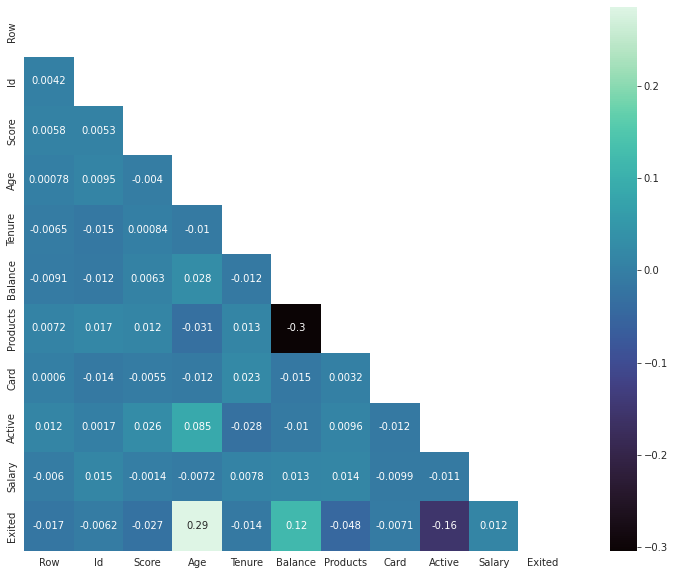

In [15]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(data.corr(), mask=mask, square=True, annot = True, cmap = 'mako')
plt.show()

In [16]:
#gets geolocation of clients
countries = data['Nationality'].unique()
coords = pd.DataFrame()
for i in countries:
    x = my_geocoder(i)
    coords = pd.concat([coords, x], axis = 1)
coords = coords.transpose()
coords['Nationality'] = countries

In [17]:
coords

,Latitude,Longitude,Nationality
0,46.603354,1.888334,France
0,39.326068,-4.837979,Spain
0,51.083420,10.423447,Germany


In [18]:
#data[['Latitude', 'Longitude']] = coords
data = data.merge(coords, left_on = 'Nationality', right_on = 'Nationality', how = 'left')
data

,Row,Id,Surname,Score,Nationality,Gender,Age,Tenure,Balance,Products,Card,Active,Salary,Exited,Latitude,Longitude
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,46.603354,1.888334
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,39.326068,-4.837979
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,46.603354,1.888334
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,46.603354,1.888334
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,39.326068,-4.837979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,46.603354,1.888334
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,46.603354,1.888334
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,46.603354,1.888334
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,51.083420,10.423447


In [19]:
#transforms data into a GeoDataFrame
geo = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
geo

,Row,Id,Surname,Score,Nationality,Gender,Age,Tenure,Balance,Products,Card,Active,Salary,Exited,Latitude,Longitude,geometry
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,46.603354,1.888334,POINT (1.88833 46.60335)
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,39.326068,-4.837979,POINT (-4.83798 39.32607)
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,46.603354,1.888334,POINT (1.88833 46.60335)
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,46.603354,1.888334,POINT (1.88833 46.60335)
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,39.326068,-4.837979,POINT (-4.83798 39.32607)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,46.603354,1.888334,POINT (1.88833 46.60335)
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,46.603354,1.888334,POINT (1.88833 46.60335)
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,46.603354,1.888334,POINT (1.88833 46.60335)
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,51.083420,10.423447,POINT (10.42345 51.08342)


In [20]:
m = folium.Map(location=[40.0,10.0], tiles='openstreetmap', zoom_start=4)
# Add points to the map
mc = MarkerCluster()
for idx, row in geo.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']]))
m.add_child(mc)
m

There's not really useful information on this map, but it is a cool way to visualize the data. For this reason, we are dropping these informations in the next step.

In [21]:
df = data.copy()
df.drop(['Row', 'Id', 'Surname', 'Latitude', 'Longitude', 'geometry'], axis = 1, inplace=True)

In [22]:
#encodes categorical features as dummy variables
df = pd.get_dummies(df, columns = ['Nationality', 'Gender'])
df

,Score,Age,Tenure,Balance,Products,Card,Active,Salary,Exited,Nationality_France,Nationality_Germany,Nationality_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0,1


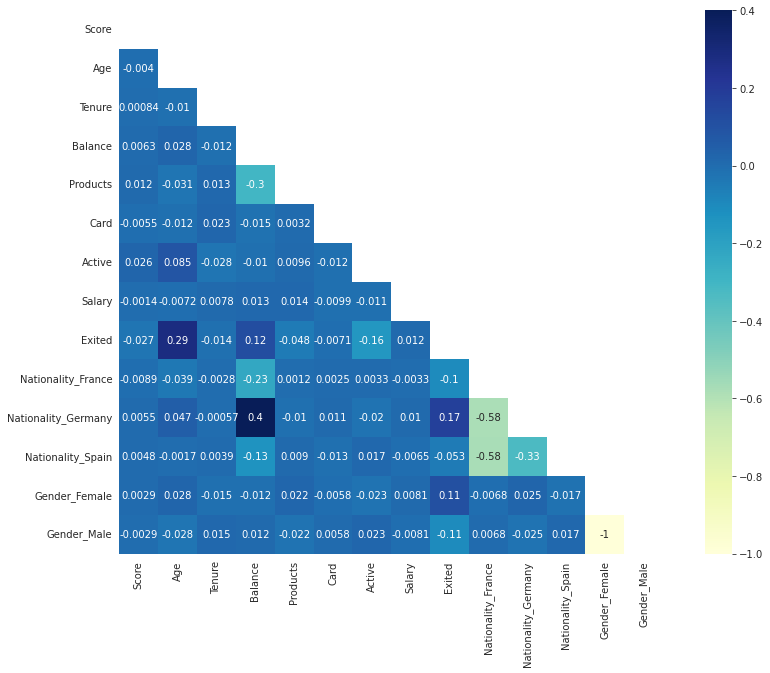

In [23]:
#visualizes correlations as a heatmap
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(df.corr(), mask=mask, square=True, annot = True, cmap = 'YlGnBu')
plt.show()

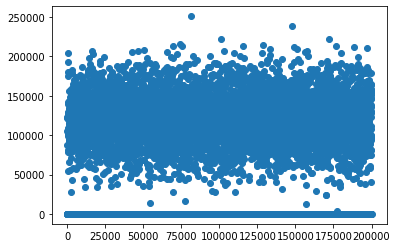

In [24]:
plt.scatter(df['Salary'], df["Balance"])

As we can see, and is confirmed by the correlation matrix, the Balance and Salary have near 0 correlation

In [25]:
df[df['Balance'] == 0].Balance.value_counts()

0.0    3617
Name: Balance, dtype: int64

There's a lot of zeroes in the Balance column, but it's not clear wether its a true value or just missing data, so we will leave it that way.

### Modelling and Scoring
    We use the above defined functions to evaluate classification models and see how well we can predict the churns.
    We are using the XGBoost algorithm to classify customers that might churn from our business using the 'binary:hinge' objective, which rounds the results into 0 or 1 for each customer.

In [29]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [300, 500, 800, 1000]}
xgbc = XGBClassifier(seed = 20, use_label_encoder=False, objective='binary:hinge')
cross_val(df, xgbc, params, 10)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.6}
Best score:  0.8259264271963266


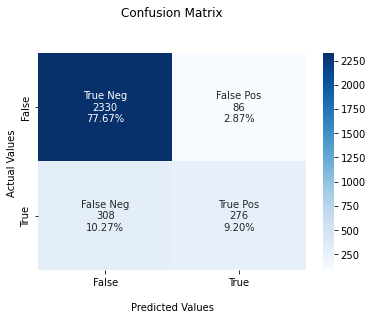

The f1-score of the model is: 0.58351


In [30]:
#build a XGBoost Classifier using a hinge objective, which means the model returns only 0 or 1 for a given customer
#also uses cross-validation and grid-search to improve the performance
model = XGBClassifier(seed = 20, use_label_encoder=False, objective='binary:hinge',
                         subsample = 0.5,
                         colsample_bytree = 0.7,
                         colsample_bylevel = 0.9,
                         max_depth = 15,
                         n_estimators = 300,
                         learning_rate = 0.01)
score_classification(model, df)

We are using the F1-score because it takes the harmonic mean of the precision and recall measures, yielding a more balanced metric.

In [31]:
# build knn model
params = {'n_neighbors': [3, 5, 7, 9, 11, 21],
          'weights': ['uniform', 'distance']}
knn_model = KNeighborsClassifier()
cross_val(df, knn_model, params, 20)

C:\Users\lucas.degi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'weights': 'distance', 'n_neighbors': 5}
Best score:  0.7952526186523106


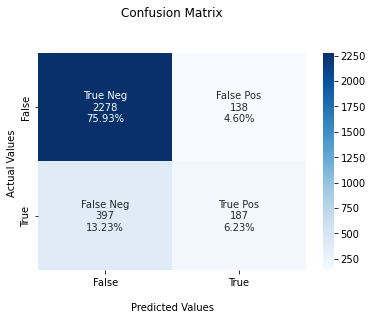

The f1-score of the model is: 0.41144


In [206]:
best_knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
score_classification(best_knn, df)

The XGBoost model performed better, as could be expected.

### Feature Engineering
    Since our normal features don't show a lot of correlation we try using PCA to maybe improve the performance of the models

In [33]:
params = {'n_neighbors': [3, 5, 7, 9, 11, 21],
          'weights': ['uniform', 'distance']}
knn_model = KNeighborsClassifier()
cross_val(df, knn_model, params, 20, pca = 'yes')

C:\Users\lucas.degi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'weights': 'uniform', 'n_neighbors': 5}
Best score:  0.7855542998893912


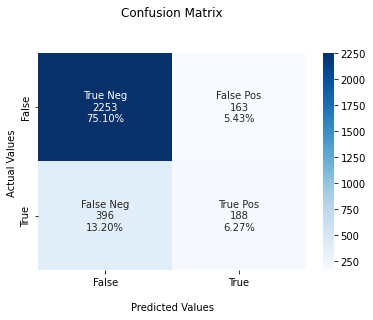

The f1-score of the model is: 0.40214


In [34]:
best_knn = KNeighborsClassifier(n_neighbors= 5, weights= 'uniform')
score_classification(best_knn, df, pca = 'yes')

In [35]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [300, 500, 800, 1000]}
xgbc = XGBClassifier(seed = 20, use_label_encoder=False, objective='binary:hinge')
cross_val(df, xgbc, params, 20, pca = 'yes')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.5}
Best score:  0.8328896085427004


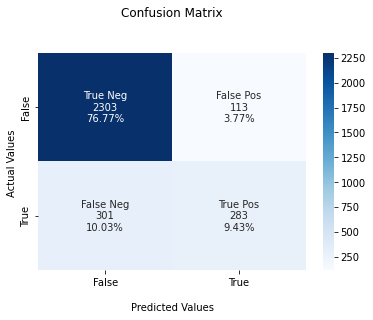

The f1-score of the model is: 0.57755


In [36]:
best_xgbc = XGBClassifier(use_label_encoder=False, objective='binary:hinge',
                         subsample = 0.5,
                         colsample_bytree = 0.8,
                         colsample_bylevel = 0.9,
                         max_depth = 10,
                         n_estimators = 500,
                         learning_rate = 0.01)
score_classification(best_xgbc, df, pca = 'yes')

Overall, this implementation of PCA didn't work out better than the standard model.

#### Improvements

    Implement probability of churn for each customer, instead of just 0s and 1s.